# ValidateDONutrients

Ben Roberts, 2022

Perform a validation of FVCOM-ICM water quality parameter output against observations compiled in a [database](https://github.com/bedaro/puget_sound_obsdata). This is loosely based on a Python notebook I wrote in summer 2020 for validation of King County's Puget Sound Aquatic Biogeochemical Cycling (PSABC) model, and most of the plots are designed to mimic the ones Ecology uses in their Bounding Scenarios report.

## Parameters

 * `model_output_pattern`: A glob pattern of all the NetCDF files from the model run. Supports single or multiple NetCDF files, either in the ICMv4 format or Ecology's NetCDF format.
 * `run_name`: The name of this particular run, used to name the output files.
 * `start_date`: A plain text start date for when the model run began, which will be read with pd.Timestamp.
 * `end_date`: A plain text end date for when to stop validating the model output. This can just be set to None to use the end of the model output, but some ways to run the model let it continue running after boundary condition files have ended, and after that point this will corrupt the fit statistics.
 * `exclude_station_ids`: A sequence of station IDs to exclude from the validation, even though they fall within the model domain and had observations during the run period.
 * `stats_max_per_station`: To deal with automated buoys that have observations at a much higher frequency than human-collected data, any station with a total number of observations that exceeds this threshold will be subsampled randomly.

In [1]:
#model_output_pattern = '/net/babaracus/home/benr/wqmodels/ssm/newinputs/1_control/wqm_year1/outputs/ssm_output.nc'
#run_name = 'newinput_ctrl_year1'
#start_date = '2014-01-01'
#end_date = '2014-12-31'
#end_date = None
model_output_pattern = '/net/babaracus/home/benr/wqmodels/ssm/ecology_bounding_outputs/2008_SSM4_WQ_Exist1_nodes.nc'
run_name = 'ecol_2008_SSM4_Exist1'
start_date = '2008-01-01'
end_date = None

# Don't validate with data from the Pacific coast (Willapa Bay, Grays Harbor)
exclude_station_ids = ('WPA001','WPA003','WPA004','WPA006','WPA007',
                       'WPA008','WPA102','WPA113','GYS004','GYS008',
                       'GYS009','GYS015','GYS016')
# To exclude all the automated buoys add:
# 'CI','HC_HP','HC_DB','HC_NB','HC_TW','PointWilliams'
stats_max_per_station = 240

import glob
import os
import os.path as path
import numpy as np
import pandas as pd
from netCDF4 import Dataset,MFDataset
import matplotlib.pyplot as plt
import contextily as cx
import db
from fvcom.grid import FvcomGrid
import validation_util as vu

Open the model output, being smart enough to handle the case where there's only a single NetCDF file rather than multiple.

In [2]:
if len(glob.glob(model_output_pattern)) == 1:
    model_output = Dataset(model_output_pattern)
else:
    model_output = MFDataset(model_output_pattern)
model_output

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): IJK(160120), Time(8760)
    variables(dimensions): float32 Var_1(Time, IJK), float32 Var_2(Time, IJK), float32 Var_3(Time, IJK), float32 Var_4(Time, IJK), float32 Var_5(Time, IJK), float32 Var_6(Time, IJK), float32 Var_7(Time, IJK), float32 Var_8(Time, IJK), float32 Var_9(Time, IJK), float32 Var_10(Time, IJK), float32 Var_11(Time, IJK), float32 Var_12(Time, IJK), float32 Var_13(Time, IJK), float32 Var_14(Time, IJK), float32 Var_15(Time, IJK), float32 Var_16(Time, IJK), float32 Var_17(Time, IJK), float32 Var_18(Time, IJK), float32 Var_19(Time, IJK), float32 Var_20(Time, IJK), float32 Var_21(Time, IJK), float32 Var_22(Time, IJK), float32 Var_23(Time, IJK), float32 Var_24(Time, IJK), float32 Var_25(Time, IJK), float32 Var_26(Time, IJK), float32 Var_27(Time, IJK), float32 Var_28(Time, IJK), float32 Var_29(Time, IJK), float32 Var_30(Time, IJK), float32 Var_31(Time, IJK), float32 Var_

In [3]:
out_file = lambda name: path.join("notebook_outs", run_name, name)
os.makedirs(os.path.dirname(out_file('foo')), exist_ok=True)

In [4]:
if 'Var_1' in model_output.variables:
    grid = FvcomGrid.from_mesh('../SSM_Grid/Salish_Sea_Shelf_top_0.2_DZ_10_3_16.2dm')
    v = vu.EcolModelValidator(start_date, model_output, grid, end_date=end_date)
else:
    v = vu.ModelValidator(start_date, model_output, end_date=end_date)

display(f'Validation range from {v.start_date} to {v.end_date}')

'Validation range from 2008-01-01 08:00:00+00:00 to 2008-12-31 08:00:00+00:00'

In [5]:
(o2_obs, nh4_obs, no23_only_obs, no3_obs, no2_obs), station_nodes = v.get_obsdata(('o2','nh4','no23','no3','no2'),
                                                                                  exclude_stations=exclude_station_ids)

print(f'{len(o2_obs)} total DO measurements in {len(o2_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
display(o2_obs.head())

# NH4: Fix units to match the model output
nh4_obs['value'] *= 14.01/1000
print(f'{len(nh4_obs)} total NH4 measurements in {len(nh4_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
display(nh4_obs.head())

print(f'{len(no23_only_obs)} total NO2+3 measurements in {len(no23_only_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
display(no23_only_obs.head())

print(f'{len(no3_obs)} total NO3 measurements in {len(no3_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
display(no3_obs.head())

print(f'{len(no2_obs)} total NO2 measurements in {len(no2_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
display(no2_obs.head())

543096 total DO measurements in 7417 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
58709148,2008-01-01 08:14:27.999974+00:00,1.663149,8.935123,HC_TW,ba4e2e0e-eaf9-4650-a452-a411e30e758f,o2,Twanoh ORCA Buoy,POINT (499373.416 5246837.904),13869
58709149,2008-01-01 08:14:43.250006+00:00,2.466857,8.578889,HC_TW,ba4e2e0e-eaf9-4650-a452-a411e30e758f,o2,Twanoh ORCA Buoy,POINT (499373.416 5246837.904),13869
58709150,2008-01-01 08:14:50.249961+00:00,3.481071,7.771732,HC_TW,ba4e2e0e-eaf9-4650-a452-a411e30e758f,o2,Twanoh ORCA Buoy,POINT (499373.416 5246837.904),13869
58709151,2008-01-01 08:14:57.250003+00:00,4.480857,7.025957,HC_TW,ba4e2e0e-eaf9-4650-a452-a411e30e758f,o2,Twanoh ORCA Buoy,POINT (499373.416 5246837.904),13869
58709152,2008-01-01 08:15:04.249958+00:00,5.449786,5.860707,HC_TW,ba4e2e0e-eaf9-4650-a452-a411e30e758f,o2,Twanoh ORCA Buoy,POINT (499373.416 5246837.904),13869


1149 total NH4 measurements in 0 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
18092620,2008-02-05 08:14:32+00:00,0.43,0.001541,P7,None,nh4,None,POINT (528355.034 5314591.753),6634
18092622,2008-02-05 08:14:32+00:00,3.21,0.000140,P7,None,nh4,None,POINT (528355.034 5314591.753),6634
18092625,2008-02-05 08:14:32+00:00,7.59,0.001821,P7,None,nh4,None,POINT (528355.034 5314591.753),6634
18092627,2008-02-05 08:14:32+00:00,11.90,0.000420,P7,None,nh4,None,POINT (528355.034 5314591.753),6634
18092629,2008-02-05 08:14:32+00:00,16.36,0.001401,P7,None,nh4,None,POINT (528355.034 5314591.753),6634


792 total NO2+3 measurements in 0 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
18325927,2008-01-28 20:27:00+00:00,74.4,32.476802,LTED04,None,no23,INNER ELLIOTT BAY SHORE/UW BXI300E/,POINT (548367.600 5272448.755),10635
18325929,2008-01-28 20:29:00+00:00,54.6,32.548180,LTED04,None,no23,INNER ELLIOTT BAY SHORE/UW BXI300E/,POINT (548367.600 5272448.755),10635
18325931,2008-01-28 20:30:00+00:00,35.0,32.191292,LTED04,None,no23,INNER ELLIOTT BAY SHORE/UW BXI300E/,POINT (548367.600 5272448.755),10635
18325933,2008-01-28 20:31:00+00:00,25.0,32.191292,LTED04,None,no23,INNER ELLIOTT BAY SHORE/UW BXI300E/,POINT (548367.600 5272448.755),10635
18325935,2008-01-28 20:32:00+00:00,15.1,31.977159,LTED04,None,no23,INNER ELLIOTT BAY SHORE/UW BXI300E/,POINT (548367.600 5272448.755),10635


828 total NO3 measurements in 0 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
18083265,2008-02-05 08:14:32+00:00,0.43,30.89,P7,None,no3,None,POINT (528355.034 5314591.753),6634
18083266,2008-02-05 08:14:32+00:00,3.21,30.85,P7,None,no3,None,POINT (528355.034 5314591.753),6634
18083267,2008-02-05 08:14:32+00:00,7.59,30.59,P7,None,no3,None,POINT (528355.034 5314591.753),6634
18083268,2008-02-05 08:14:32+00:00,11.90,30.55,P7,None,no3,None,POINT (528355.034 5314591.753),6634
18083269,2008-02-05 08:14:32+00:00,16.36,30.50,P7,None,no3,None,POINT (528355.034 5314591.753),6634


823 total NO2 measurements in 0 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
18087968,2008-02-05 08:14:32+00:00,0.43,0.17,P7,None,no2,None,POINT (528355.034 5314591.753),6634
18087969,2008-02-05 08:14:32+00:00,3.21,0.17,P7,None,no2,None,POINT (528355.034 5314591.753),6634
18087970,2008-02-05 08:14:32+00:00,7.59,0.17,P7,None,no2,None,POINT (528355.034 5314591.753),6634
18087971,2008-02-05 08:14:32+00:00,11.90,0.17,P7,None,no2,None,POINT (528355.034 5314591.753),6634
18087972,2008-02-05 08:14:32+00:00,16.36,0.17,P7,None,no2,None,POINT (528355.034 5314591.753),6634


In [6]:
station_nodes.head()

,description,geom,node
name,,,
CSE002,Case Inlet - Off Rocky Point,POINT (514099.002 5244447.120),15720
HCB010,"Hood Canal - Send Creek, Bangor Post 9/11/2001...",POINT (513512.242 5279306.044),9887
HLM001,Holmes Harbor - Honeymoon Bay,POINT (534889.134 5323445.816),9931
PNN001,Penn Cove Park Whidbey Island,POINT (524133.659 5342101.577),8999
SIN001,Sinclair Inlet - Naval Shipyards,POINT (526958.030 5266349.377),11793


Combine NO3 and NO2 measurements, then add them to the no23_obs DataFrame

NB: This assumes there is a matching NO3 measurement for every NO2 measurement. That's dangerous, as if any NO3 measurements are missing, I'm not sure how the addition of the Series is handled. It should result in a NaN that needs to be dropped.

In [7]:
common_idx = ['datetime','location_id','depth']
combined_no23 = no3_obs.set_index(common_idx).merge(no2_obs.set_index(common_idx)[['value']], left_index=True, right_index=True)
combined_no23['value'] = combined_no23['value_x'] + combined_no23['value_y']
del combined_no23['value_x']
del combined_no23['value_y']
combined_no23.reset_index(inplace=True)
combined_no23.head()

,datetime,location_id,depth,cast_id,parameter_id,description,geom,node,value
0,2008-02-05 08:14:32+00:00,P7,0.43,None,no3,None,POINT (528355.034 5314591.753),6634,31.06
1,2008-02-05 08:14:32+00:00,P7,3.21,None,no3,None,POINT (528355.034 5314591.753),6634,31.02
2,2008-02-05 08:14:32+00:00,P7,7.59,None,no3,None,POINT (528355.034 5314591.753),6634,30.76
3,2008-02-05 08:14:32+00:00,P7,11.90,None,no3,None,POINT (528355.034 5314591.753),6634,30.72
4,2008-02-05 08:14:32+00:00,P7,16.36,None,no3,None,POINT (528355.034 5314591.753),6634,30.67


In [8]:
no23_obs = pd.concat([no23_only_obs, combined_no23])
# Fix units to match the model output
no23_obs['value'] *= 14.01/1000
print(f'{len(no23_obs)} total NO2+NO3 measurements')
print(f'{len(no23_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
no23_obs.head()

1615 total NO2+NO3 measurements
0 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
18325927,2008-01-28 20:27:00+00:00,74.4,0.455,LTED04,None,no23,INNER ELLIOTT BAY SHORE/UW BXI300E/,POINT (548367.600 5272448.755),10635
18325929,2008-01-28 20:29:00+00:00,54.6,0.456,LTED04,None,no23,INNER ELLIOTT BAY SHORE/UW BXI300E/,POINT (548367.600 5272448.755),10635
18325931,2008-01-28 20:30:00+00:00,35.0,0.451,LTED04,None,no23,INNER ELLIOTT BAY SHORE/UW BXI300E/,POINT (548367.600 5272448.755),10635
18325933,2008-01-28 20:31:00+00:00,25.0,0.451,LTED04,None,no23,INNER ELLIOTT BAY SHORE/UW BXI300E/,POINT (548367.600 5272448.755),10635
18325935,2008-01-28 20:32:00+00:00,15.1,0.448,LTED04,None,no23,INNER ELLIOTT BAY SHORE/UW BXI300E/,POINT (548367.600 5272448.755),10635


In [9]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in o2_obs.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(o2_obs.loc[o2_obs['cast_id'].isna()]))

o2_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
o2_validation_df.to_csv(out_file("o2_validation.csv"), index=False)
o2_validation_df

,location,node,cast_id,datetime,t,depth,sigma,observed,model
0,HC_TW,13869,0011d8d9-f30f-43e6-a63c-accc1148f354,2008-12-11 16:15:41.999990+00:00,8288,2.321215,2,8.172522,10.12700
1,HC_TW,13869,0011d8d9-f30f-43e6-a63c-accc1148f354,2008-12-11 16:15:41.999990+00:00,8288,4.865385,3,4.644147,8.97459
2,HC_TW,13869,0011d8d9-f30f-43e6-a63c-accc1148f354,2008-12-11 16:15:41.999990+00:00,8288,8.000963,4,2.991767,5.61038
3,HC_TW,13869,0011d8d9-f30f-43e6-a63c-accc1148f354,2008-12-11 16:15:41.999990+00:00,8288,11.629237,5,2.429265,2.71217
4,HC_TW,13869,0011d8d9-f30f-43e6-a63c-accc1148f354,2008-12-11 16:15:41.999990+00:00,8288,15.689660,6,2.344682,1.37043
...,...,...,...,...,...,...,...,...,...
60127,P132,2375,NaN,2008-08-15 18:42:03+00:00,5459,29.660000,4,5.460000,4.42376
60128,P132,2375,NaN,2008-08-15 18:42:03+00:00,5459,51.420000,5,3.580000,3.89331
60129,P132,2375,NaN,2008-08-15 18:42:03+00:00,5459,83.500000,8,3.280000,3.03017
60130,P132,2375,NaN,2008-08-15 18:42:03+00:00,5459,114.130000,9,2.290000,2.93663


In [10]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in nh4_obs.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(nh4_obs.loc[nh4_obs['cast_id'].isna()]))

nh4_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
nh4_validation_df.to_csv(out_file("nh4_validation.csv"), index=False)
nh4_validation_df

,location,node,datetime,t,depth,sigma,observed,model
0,P7,6634,2008-02-05 08:14:32+00:00,841,0.43,0,0.001541,0.011088
1,P7,6634,2008-02-05 08:14:32+00:00,841,3.21,1,0.000140,0.011701
2,P7,6634,2008-02-05 08:14:32+00:00,841,7.59,2,0.001821,0.011699
3,P7,6634,2008-02-05 08:14:32+00:00,841,11.90,3,0.000420,0.010538
4,P7,6634,2008-02-05 08:14:32+00:00,841,16.36,4,0.001401,0.010302
...,...,...,...,...,...,...,...,...
1144,P132,2375,2008-08-15 18:42:03+00:00,5459,29.66,4,0.006445,0.023289
1145,P132,2375,2008-08-15 18:42:03+00:00,5459,51.42,5,0.000000,0.021077
1146,P132,2375,2008-08-15 18:42:03+00:00,5459,83.50,8,0.001541,0.015340
1147,P132,2375,2008-08-15 18:42:03+00:00,5459,114.13,9,0.000000,0.014869


In [11]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in no23_obs.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(no23_obs.loc[no23_obs['cast_id'].isna()]))

no23_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
no23_validation_df.to_csv(out_file("no23_validation.csv"), index=False)
no23_validation_df

,location,node,datetime,t,depth,sigma,observed,model
0,LTED04,10635,2008-01-28 20:27:00+00:00,661,74.40,10,0.455000,0.418416
1,LTED04,10635,2008-01-28 20:29:00+00:00,661,54.60,8,0.456000,0.424114
2,LTED04,10635,2008-01-28 20:30:00+00:00,661,35.00,6,0.451000,0.425979
3,LTED04,10635,2008-01-28 20:31:00+00:00,661,25.00,5,0.451000,0.426102
4,LTED04,10635,2008-01-28 20:32:00+00:00,661,15.10,3,0.448000,0.426516
...,...,...,...,...,...,...,...,...
1610,P132,2375,2008-08-15 18:42:03+00:00,5459,29.66,4,0.377850,0.378870
1611,P132,2375,2008-08-15 18:42:03+00:00,5459,51.42,5,0.466253,0.410213
1612,P132,2375,2008-08-15 18:42:03+00:00,5459,83.50,8,0.458127,0.473252
1613,P132,2375,2008-08-15 18:42:03+00:00,5459,114.13,9,0.503099,0.479233


,Metric,R,RMSE,Bias,n
0,Dissolved Oxygen,0.785902,1.385480,-0.297576,5130
1,Ammonia,0.532317,0.016648,0.008834,1149
2,Total Nitrate+Nitrite,0.680086,0.083585,-0.026723,1615


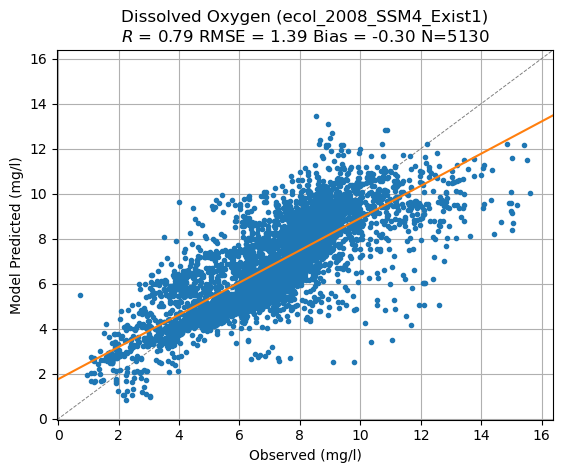

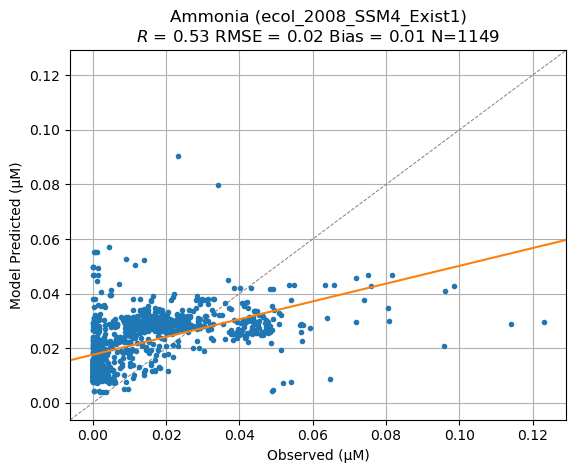

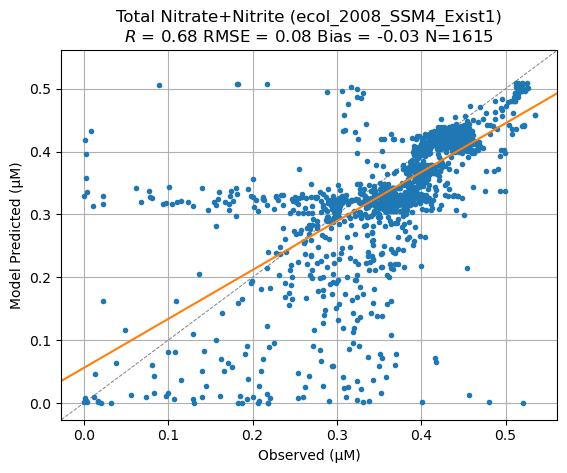

In [12]:
cum_stats = []
for pfx, label, data, unit in zip(("o2","nh4","no23"),
        ("Dissolved Oxygen","Ammonia","Total Nitrate+Nitrite"),
        (o2_validation_df,nh4_validation_df,no23_validation_df),
        ("mg/l","\u03BCM","\u03BCM")):
    if data.empty:
        continue
    # Downsample any stations with a high number of total observations
    # (ie automated buoys), otherwise a small number of stations will skew
    # the results heavily toward just showing how well the model represents
    # a handful of locations
    sampled = []
    for s,group in data.groupby('location'):
        if len(group) > stats_max_per_station:
            samp = group.sample(n=stats_max_per_station)
        else:
            samp = group
        sampled.append(samp)
    sampled_df = pd.concat(sampled)
    fit, rsq, rmse, bias, n = vu.run_stats(sampled_df["observed"], sampled_df["model"])
    fig, ax = plt.subplots()
    vu.plot_fit(ax, sampled_df['observed'], sampled_df['model'], f'{label} ({run_name})', unit=unit)
    fig.savefig(out_file(f'{pfx}_validation.png'))
    cum_stats.append([label, rsq, rmse, bias, n])

display(pd.DataFrame(cum_stats, columns=["Metric","R","RMSE","Bias","n"]))

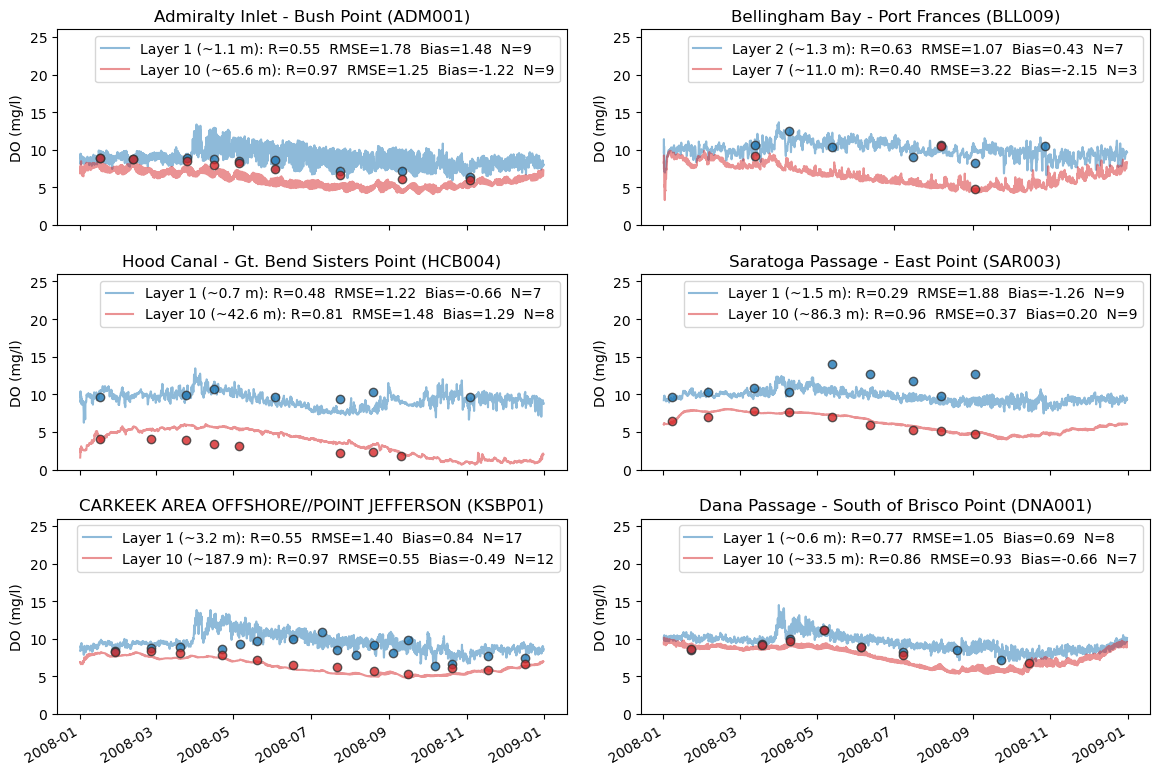

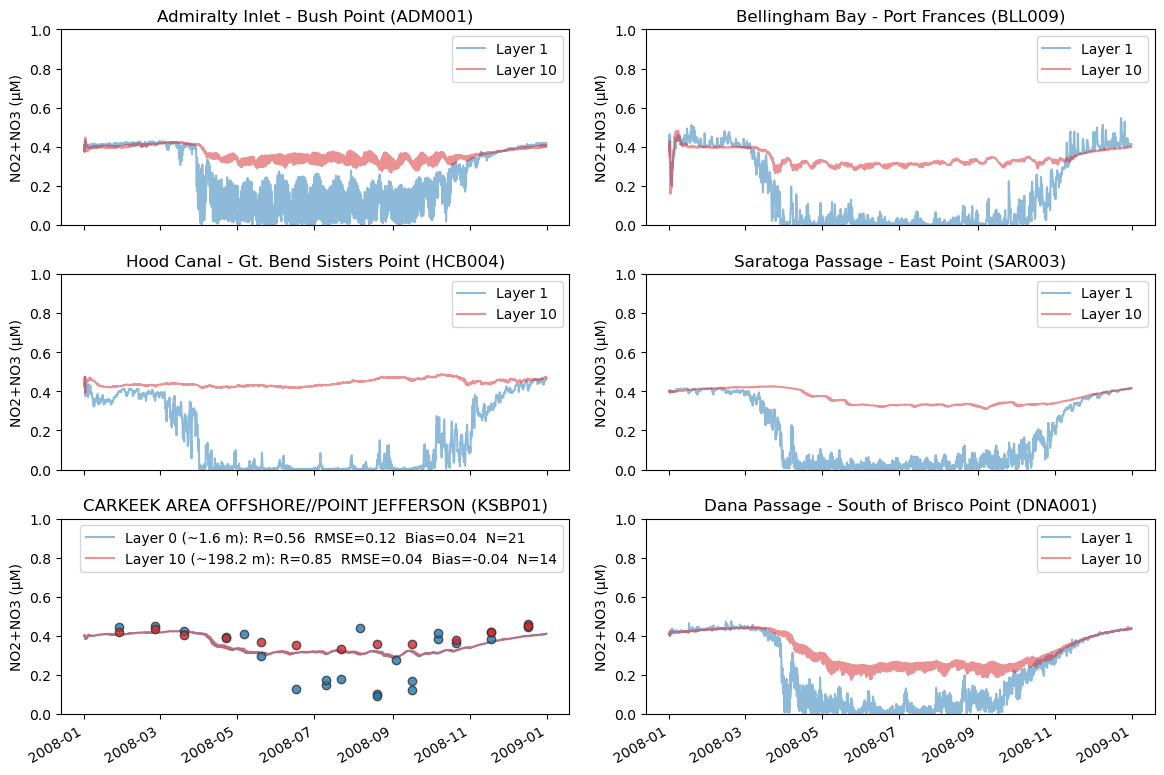

In [13]:
# Build time series plots of DO and nutrients that
# mimic fig 21 in the Bounding Scenarios report

plot_stations = ["ADM001","BLL009","HCB004","SAR003","KSBP01","DNA001"]
colors = ('tab:blue','tab:red')
datasets = {
    "o2": {
        "data": o2_validation_df,
        "obsdata": o2_obs,
        "ylabel": "DO (mg/l)",
        "ybound": (0, 26),
        "xbound": (0, 26)
    },
    "no23": {
        "data": no23_validation_df,
        "obsdata": no23_obs,
        "ylabel": "NO2+NO3 (\u03BCM)",
        "ybound": (0, 1),
        "xbound": (0, 1)
    }
}

for key,vals in datasets.items():
    data = vals['data']
    fig, axs = plt.subplots(3,2, figsize=(12,9))
    for ax,s in zip(np.array(axs).flatten(), plot_stations):
        zs = vu.tsplot_zs(v, data.loc[data['location'] == s])
        for z,color in zip(zs, colors):
            selector = (data["location"] == s) & (data["sigma"] == z)
            observed = data.loc[selector]
            if len(observed) == 0:
                # No observations at this station!
                node = station_nodes.loc[s, 'node']
                lbl = f'Layer {z}'
            else:
                havg = observed['depth'].mean()
                lbl = f'Layer {z} (~{havg:.1f} m)'
                node = observed.iloc[0]['node']
                ax.plot(observed["datetime"], observed["observed"], "o",
                        color=color, alpha=0.8, markeredgecolor='.2', zorder=2)

                if len(observed) > 2:
                    fit, r, rmse, bias, n = vu.run_stats(observed["observed"],
                                                         observed["model"])
                    lbl += ": R=%.2f  RMSE=%.2f  Bias=%.2f  N=%d" % (r, rmse, bias, n)

            # Extract the full time series from the output file
            modeled_y = v.get_model_match(key, slice(None), z-1,node-1)
            modeled_x = v.get_times()
            ax.plot(modeled_x, modeled_y, color=color, alpha=0.5, label=lbl, zorder=1)
        ax.set(title=f'{station_nodes.loc[s, "description"]} ({s})',
               ylabel=vals['ylabel'], ybound=vals['ybound'])
        ax.legend()
    plt.tight_layout()
    fig.autofmt_xdate()
    fig.savefig(out_file(f'{key}_validation_station_ts.png'))

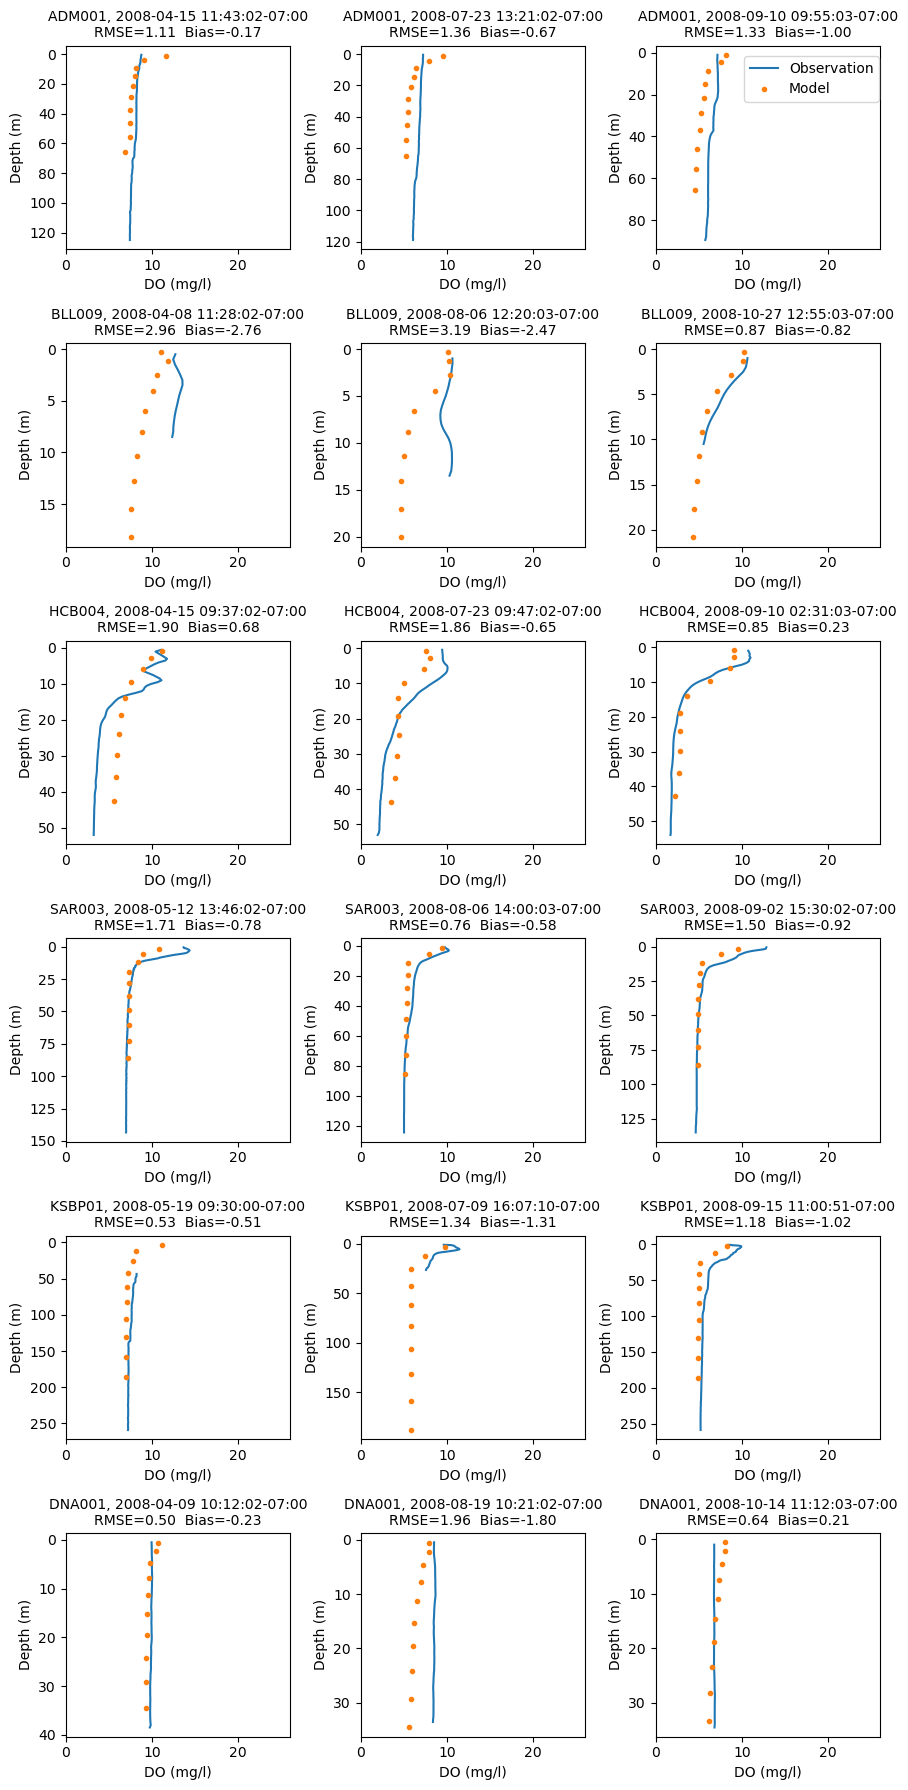

In [14]:
# Ranges of months to generate profile plots for
month_ranges = (
    (4, 5),
    (7, 8),
    (9, 10)
)
rand_seed = 4

for key,vals in datasets.items():
    fig, axs = plt.subplots(len(plot_stations), len(month_ranges),
                            figsize=(3*len(month_ranges), 3 * len(plot_stations)))
    d = vals['data']
    od = vals['obsdata']
    # Keep track of whether or not we found anything to plot among the ranges
    # given from this dataset
    plotted = False
    for i,mr in enumerate(month_ranges):
        for j,s in enumerate(plot_stations):
            ax = axs[j,i]
            # Pick a "random" cast from the time range, using a constant seed for reproducibility
            cast_candidates = od.loc[
                (od['datetime'].dt.month >= mr[0]) & (od['datetime'].dt.month <= mr[-1]) \
                & (od['location_id'] == s) & ~od['cast_id'].isna(), 'cast_id'
            ]
            if len(cast_candidates) == 0:
                continue
            obs_cast_id = cast_candidates.sample(1, random_state=rand_seed).iloc[0]

            obs = od.loc[od['cast_id'] == obs_cast_id].sort_values(by='depth')
            lobs, = ax.plot(obs['value'], obs['depth'], label='Observation')
            cast_dt = obs['datetime'].iloc[0].tz_convert('US/Pacific')

            # Get model results that correspond to this cast_id. Use vals['data'] to fetch node and t,
            # retrieve all sigma layers, then recalculate matching depths using the same method as
            # process_cast
            node = obs['node'].iloc[0]
            cast_selector = d['cast_id'] == obs_cast_id
            t = d.loc[cast_selector, 't'].iloc[0]
            modeled_x = v.get_model_match(key, t, slice(None), node-1)
            modeled_y = ((v.grid.ncoord[2, node-1] + v._get_ssh(t, node-1))
                         * v.depthcoord.zz[:-1] * -1)
            lmodel, = ax.plot(modeled_x, modeled_y, '.', label='Model')
            
            fit, r, rmse, bias, n = vu.run_stats(d.loc[cast_selector, "observed"],
                                                 d.loc[cast_selector, "model"])

            ax.set_title(f'{s}, {cast_dt}\nRMSE={rmse:.2f}  Bias={bias:.2f}', fontsize=10)
            ax.set(ylabel='Depth (m)', xlabel=vals['ylabel'], xbound=vals['xbound'])
            ax.set_ylim(ax.get_ylim()[::-1]) #this reverses the yaxis (i.e. deep at the bottom)
            plotted = True

    if plotted:
        fig.tight_layout()
        fig.legend((lobs, lmodel), ('Observation','Model'), loc='upper right', bbox_to_anchor=(0.99, 0.97))
        fig.savefig(out_file(f'{key}_validation_station_pr.png'))
    else:
        plt.close(fig)

DO skill over time

In [15]:
per_month = []
for name, group in o2_validation_df.groupby(o2_validation_df["datetime"].dt.date):
    fit, rsq, rmse, bias, n = vu.run_stats(group['observed'], group['model'])
    per_month.append([name, rsq, rmse, bias, n])

per_month_stats = pd.DataFrame(per_month, columns=["Date","R","RMSE","Bias","n"])
per_month_stats.to_csv(out_file('o2_skill_per_month.csv'))
per_month_stats

,Date,R,RMSE,Bias,n
0,2008-01-01,0.677203,1.979667,0.257657,32
1,2008-01-02,0.656119,1.947698,0.594514,32
2,2008-01-03,0.737507,1.757058,0.721371,32
3,2008-01-04,0.745263,1.643244,0.628422,32
4,2008-01-05,0.646529,2.082789,1.229531,32
...,...,...,...,...,...
361,2008-12-27,0.863109,1.237095,-0.075336,55
362,2008-12-28,0.605163,2.238491,0.916319,55
363,2008-12-29,0.878304,1.232755,0.098843,55
364,2008-12-30,0.835320,1.368269,0.064123,55


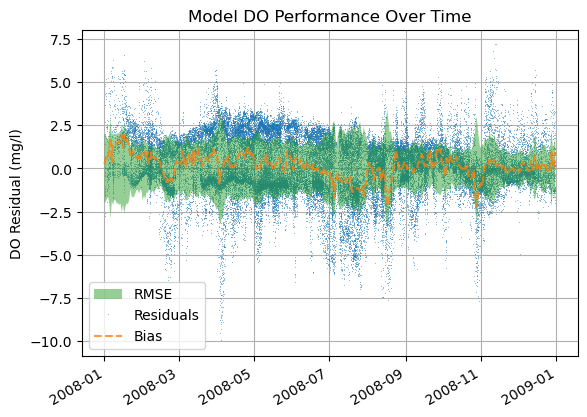

In [16]:
# Plot temperature residuals over time
o2_resids = o2_validation_df["model"] - o2_validation_df["observed"]
fig, ax = plt.subplots()
ax.fill_between(per_month_stats["Date"],
                per_month_stats["RMSE"],
                -per_month_stats["RMSE"],
                facecolor="tab:green", alpha=0.5, label="RMSE", zorder=4)
ax.plot(o2_validation_df["datetime"].to_numpy(), o2_resids, ",", label="Residuals", alpha=0.5)
ax.plot(per_month_stats["Date"].to_numpy(), per_month_stats["Bias"], "--", label="Bias", alpha=0.8, zorder=5)
ax.set(title="Model DO Performance Over Time", ylabel="DO Residual (mg/l)")
ax.grid()
ax.legend()
fig.autofmt_xdate()
fig.savefig(out_file("o2_skill_vs_t.png"))

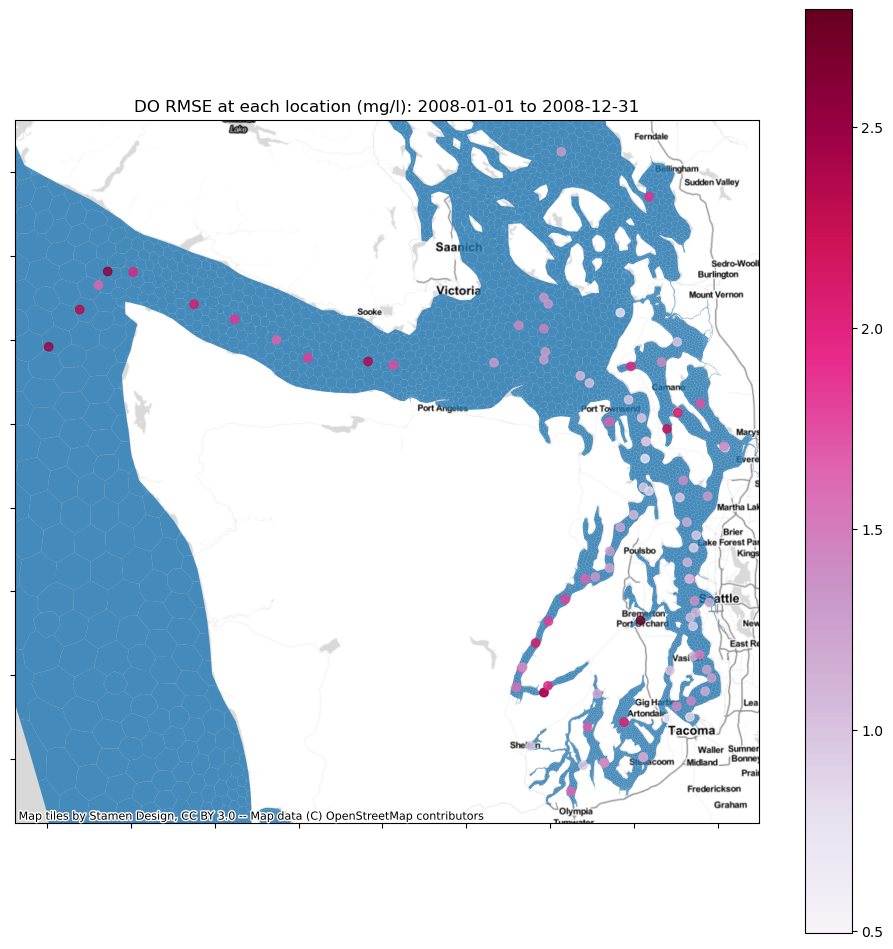

In [17]:
full_grid = v.grid.tces_gdf()
station_fits = station_nodes.copy()
station_fits['rmse'] = np.nan
for l,group in o2_validation_df.groupby('location'):
    fit, rsq, rmse, bias, n = vu.run_stats(group['observed'], group['model'])
    station_fits.loc[l, 'rmse'] = rmse
fig, ax = plt.subplots(figsize=(12,12))
p = station_fits.plot(ax=ax, column='rmse', zorder=2, legend=True, cmap='PuRd', alpha=0.8)
# Save the axes boundaries so we can restore them after plotting the full model
# boundary
xmin, xmax, ymin, ymax = p.axis()
if False:
    # Zoom out a bit to make room for labels
    dx = (xmax - xmin) / 2
    dy = (ymax - ymin) / 2
    xmin -= 0.4 * dx
    xmax += 0.6 * dx
    #ymin -= 0.4 * dy
    #ymax += 0.4 * dy
    ax.set(xbound=(xmin, xmax), ybound=(ymin, ymax))
    from adjustText import adjust_text
    import matplotlib.patheffects as pe
    texts = station_fits.apply(
        lambda x: ax.annotate(x.name, xy=x['geom'].coords[0], ha='center', va='center',
                              path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.6)]
                             ), axis=1)
    adjust_text(texts, arrowprops=dict(arrowstyle='-'))
full_grid.plot(ax=ax, alpha=0.8, zorder=1)
ax.set(title=f'DO RMSE at each location (mg/l): {v.start_date.date()} to {v.end_date.date()}',
       ybound=(ymin, ymax), xbound=(xmin, xmax), xticklabels=(), yticklabels=())
cx.add_basemap(ax, crs=full_grid.crs, source=cx.providers.Stamen.TonerLite)
if True:
    fig.savefig(out_file("o2_rmse_by_station.png"))